In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from itertools import product

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import metrics

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [2]:
def parse_d(row, d_names):
    rng = range(row['groups'])
    for i, j in product(rng, rng):
        row[f'd_{i+1}{j+1}'] = row['d'][i,j]
        
    return row[d_names]

def parse_var(row, var_names, var):
    for i in range(row['groups']):
        row[f'{var}_{i+1}'] = row[var].flatten()[i]
    return row[var_names]

def parse_test(path=None):
    
    if path:
        base = pd.read_pickle(specific_file)
    else:
        l = [file_name for file_name in os.listdir() if os.path.splitext(file_name)[1] == '.pickle']

        base = pd.concat([pd.read_pickle(path) for path in l], axis=0)
        base = base[base['l'].apply(lambda x: (x!=0).all())].reset_index(drop=True)
        
        
    for col in ['sol', 'sol_gov']:
        base = pd.concat([base.drop(col, axis=1), pd.json_normalize(base[col]).add_suffix('_' + col)], axis=1)

    for col in ['cost_sol', 'cost_sol_gov']:
        base[col] = base[col].apply(lambda x: x.flatten())
        base[col] = pd.DataFrame(base[col].to_list()).sum(axis=1)


    base['sol_gap'] = base['cost_sol'] - base['cost_sol_gov']

    base['best_sol'] = base.apply(lambda row: 'gov' if row['cost_sol_gov'] < row['cost_sol'] else 'game', axis=1)
    
    base['groups'] = base['d'].apply(lambda x: x.shape[0])
    max_groups = base['groups'].max()
    rng = range(1, max_groups+1)
    
    d_names = [f'd_{i}{j}' for i, j in product(rng, rng)]
    base[d_names] = 0
    base[d_names] = base.apply(lambda row: parse_d(row, d_names), axis=1)

    l_names = [f'l_{i}' for i in rng]
    base[l_names] = 0
    base[l_names] = base.apply(lambda row: parse_var(row, l_names, 'l'), axis=1)

    v_names = [f'v_sol_{i}' for i in rng]
    base[v_names] = 0
    base[v_names] = base.apply(lambda row: parse_var(row, v_names, 'v_sol'), axis=1)
    
    return base
        
    

In [3]:
specific_file = r'/Users/danielablin/Documents/GitHub/Thesis/test_run_2022-11-22_129_300.pickle'
base = parse_test(specific_file)

In [4]:
base.groupby(['best_sol', 'msg_sol'])['best_sol'].count()

best_sol  msg_sol          
game      found solution       254
          time out              35
gov       found solution         7
          no close solution      1
          time out               3
Name: best_sol, dtype: int64

In [9]:
base[[i for i in base.columns if 'test_results' in i]]

,test_results.derv_sol,test_results.cost_derv_sol,test_results.solution_sol,test_results.derv_sol_gov,test_results.cost_derv_sol_gov,test_results.solution_sol_gov
0,True,[False],[True],True,[False],False
1,True,[False],[True],True,[False],True
2,True,[False],NaN,True,[False],False
3,True,[False],[True],True,[False],False
4,True,[False],[True],True,[False],True
...,...,...,...,...,...,...
295,True,[False],[True],True,[False],True
296,True,[False],[True],True,[False],True
297,True,[False],NaN,True,[False],False
298,True,[False],NaN,True,[False],False


In [229]:
columns = ['l_1', 'l_2', 'l_3', 'l_4', 'l_5', 'sol_gap', 'best_sol']
sns.pairplot(base[columns], hue='best_sol', diag_kind='hist')

KeyError: "['l_3', 'l_4', 'l_5'] not in index"

In [14]:
specific_file = r'/Users/danielablin/Documents/GitHub/Thesis/test_run_2022-11-10_129_1000.pickle'
specific_file = r'/Users/danielablin/Documents/GitHub/Thesis/test_run_2022-11-27_129_300.pickle'
base = parse_test(specific_file)

In [16]:
base.groupby('best_sol')['best_sol'].count()

best_sol
game    289
gov      11
Name: best_sol, dtype: int64

In [18]:
base.groupby('best_sol')['sol_gap'].mean()

best_sol
game   -0.713318
gov     8.526015
Name: sol_gap, dtype: float64

In [19]:
base.query('best_sol == "gov"')['msg_sol'].unique()

array(['no close solution', 'time out', 'found solution'], dtype=object)

In [20]:
base['test'] = base[['d_11', 'd_12', 'd_21', 'd_22', 'l_1', 'l_2']].product(axis=1)

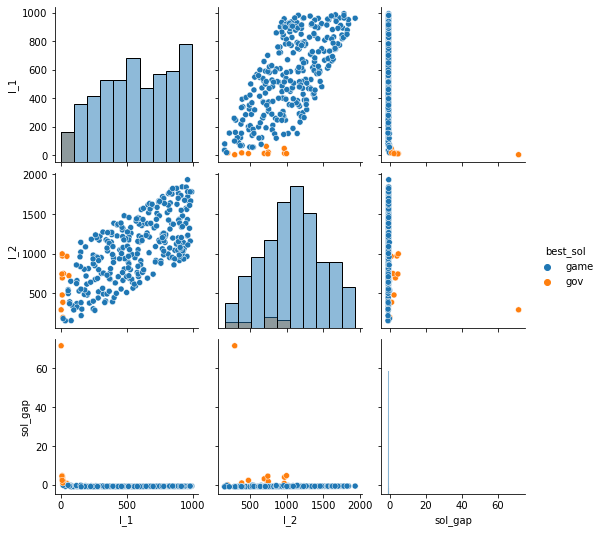

In [21]:
columns = ['l_1', 'l_2', 'sol_gap', 'best_sol']
sns.pairplot(base[columns], hue='best_sol', diag_kind='hist')

# 5 groups

In [137]:
specific_file = None
specific_file = r'/Users/danielablin/Documents/GitHub/Thesis/test_run_2022-11-14_129_300.pickle'
l = [file_name for file_name in os.listdir() if os.path.splitext(file_name)[1] == '.pickle']
groups = 5

l_list = ['l_' + str(i) for i in range(groups)]
v_list = ['v_' + str(i) for i in range(groups)]

base = pd.concat([pd.read_pickle(path) for path in l], axis=0)
base = base[base['l'].apply(lambda x: (x!=0).all())].reset_index(drop=True)

if specific_file:
    base = pd.read_pickle(specific_file)

for col in ['sol', 'sol_gov']:
    base = pd.concat([base.drop(col, axis=1), pd.json_normalize(base[col]).add_suffix('_' + col)], axis=1)
    
for col in ['cost_sol', 'cost_sol_gov']:
    base[col] = base[col].apply(lambda x: x.flatten())
    base[col] = pd.DataFrame(base[col].to_list()).sum(axis=1)
    
base[l_list] = pd.DataFrame(np.array(base['l'].to_list()).reshape(base.shape[0], groups))
base[v_list] = pd.DataFrame(np.array(base['v_sol'].to_list()).reshape(base.shape[0], groups))

base['sol_gap'] = base['cost_sol'] - base['cost_sol_gov']
base['l_t'] = base[l_list].sum(axis=1)

base['best_sol'] = base.apply(lambda row: 'gov' if row['cost_sol_gov'] < row['cost_sol'] else 'game', axis=1)


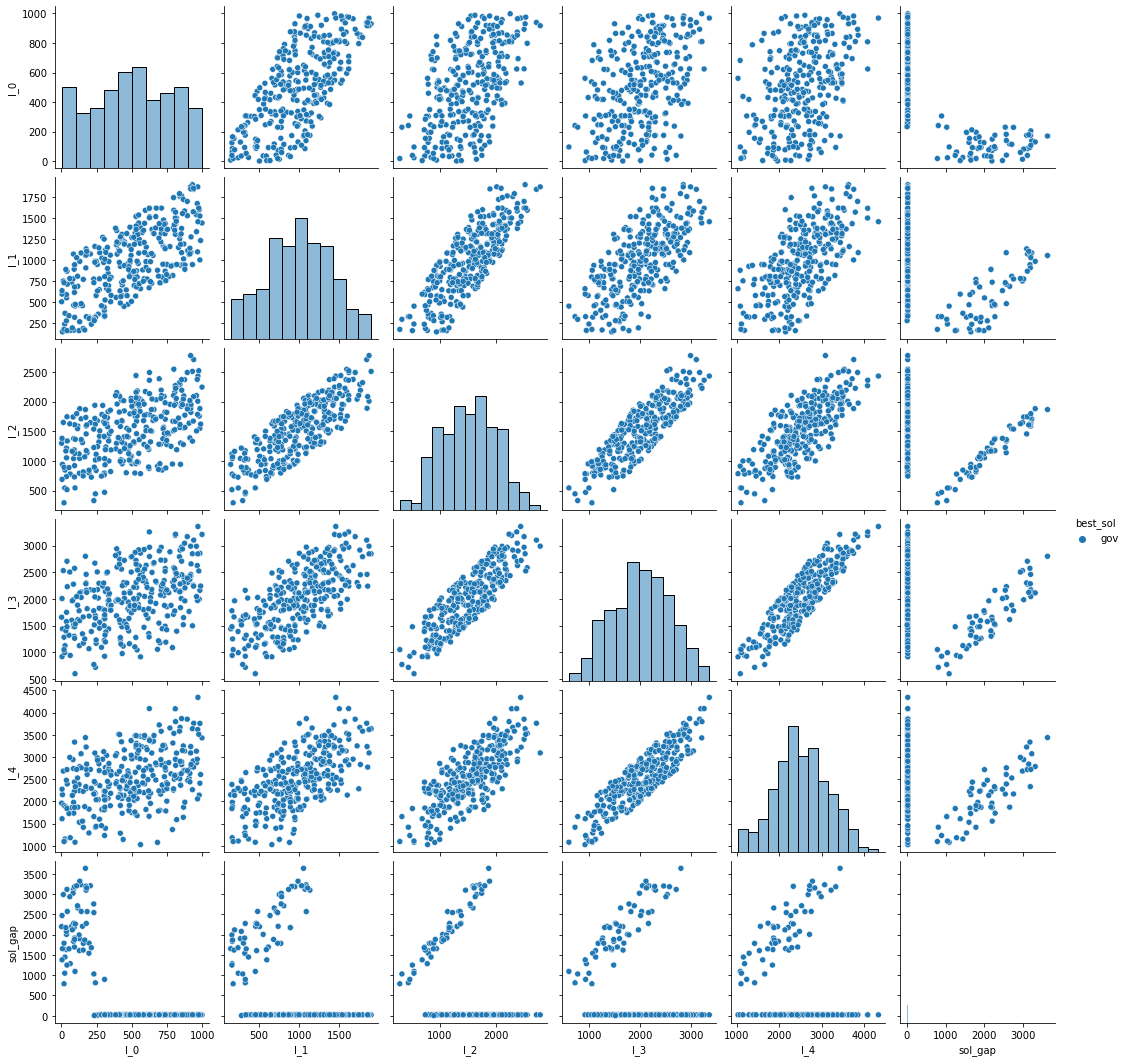

In [138]:
columns = l_list + ['sol_gap', 'best_sol']
sns.pairplot(base[columns], hue='best_sol', diag_kind='hist')

In [145]:
base['test_results.derv_sol'].value_counts()

True    300
Name: test_results.derv_sol, dtype: int64

In [147]:
base.iloc[0]['v_der_sol'].sum()

-640.9531808024917

In [129]:
base_d = pd.read_csv('d_params.csv', header=None).to_numpy()
groups = 5
d_row_split = np.array_split(base_d, groups)
d_full_split = [np.array_split(row_split, groups, axis=1) for row_split in d_row_split]
d = np.array([[split.sum() for split in row_split] for row_split in d_full_split]).T

In [132]:
d_full_split[0][0]

array([[5.54669174, 1.73315293, 0.62966517, 0.34444574],
       [1.91178931, 6.85060448, 2.02608252, 0.49688645],
       [0.754099  , 2.19974674, 8.74286752, 1.92063456],
       [0.45474071, 0.59469874, 2.11723495, 8.37986229]])

In [120]:
groups = [10]

In [127]:
d_row_split = np.split(base_d, groups)
d_full_split = [np.split(row_split, groups, axis=1) for row_split in d_row_split]
d = np.array([[split.sum(axis=0).mean() for split in row_split] for row_split in d_full_split]).T

In [128]:
d

array([[13.96027149,  3.05554234],
       [ 2.87614929,  2.00403347]])

In [85]:
np.array_split(a[0], 3, axis=1)[0].shape

(6, 6)

In [68]:
groups = 5

number_of_groups = int(base_d.shape[0] / groups)
d_reverse = []
for i in range(number_of_groups):
    
    end = base_d.shape[0] - i*groups - 1
    
    if i == number_of_groups:
        start = 0
    else:
        start = base_d.shape[0] - (i+1)*groups
    d_reverse.append(base_d[start:end, start:end])

In [71]:
d_reverse

[array([[1.05912343, 0.46049255, 0.14900805, 0.08952481],
        [0.50147315, 0.69791926, 0.25442206, 0.16527957],
        [0.26048401, 0.40841432, 0.49283785, 0.23314546],
        [0.17866536, 0.3028942 , 0.26616606, 0.47178998]]),
 array([[2.63508509, 1.67976655, 1.23930757, 0.88052278],
        [1.8175392 , 2.57013319, 1.60306436, 1.03031922],
        [1.50471681, 1.79883683, 2.08762728, 1.2206436 ],
        [1.19848934, 1.29607616, 1.36838022, 1.45463422]]),
 array([[6.85060448, 2.02608252, 0.49688645, 0.26707748],
        [2.19974674, 8.74286752, 1.92063456, 0.43491127],
        [0.59469874, 2.11723495, 8.37986229, 2.05515346],
        [0.33184558, 0.49771862, 2.13355168, 4.05206879]])]

In [39]:
groups = 2

In [41]:
np.split(base_d, [10,16])

[array([13.29495424, 15.98130145, 18.12031504, 18.61737406, 14.7726254 ,
        15.39368593, 15.64380046, 16.58064202, 15.54986346, 12.90504864]),
 array([12.1986125 ,  9.78413813,  6.66109773,  5.07279876,  4.80296875,
         4.06000829]),
 array([], dtype=float64)]

In [ ]:
if groups = 2:
    
    d = base_d[:10]

In [26]:
base.query('best_sol=="gov" and l_rate<0.5')[['d_11', 'd_12', 'd_21', 'd_22', 'l_1', 'l_2', 'l_rate']].sort_values('l_rate')

,d_11,d_12,d_21,d_22,l_1,l_2,l_rate
1796,0.216344,0.203078,0.127279,0.223260,2.5,25.0,0.100000
1073,0.088949,0.246902,0.208737,0.127716,2.5,25.0,0.100000
766,0.141109,0.179454,0.224510,0.200378,2.0,20.0,0.100000
1149,0.150691,0.240781,0.138095,0.082563,4.5,45.0,0.100000
309,0.239258,0.167837,0.170858,0.063470,1.0,10.0,0.100000
...,...,...,...,...,...,...,...
700,0.238499,0.197975,0.249199,0.231173,0.5,1.5,0.333333
1215,0.211393,0.196377,0.146888,0.234778,1.5,4.5,0.333333
1636,0.029603,0.068238,0.197800,0.200729,2.5,7.5,0.333333
1511,0.147283,0.218465,0.231567,0.079277,4.5,13.5,0.333333


In [69]:
test = base.astype(str)[['T', 'I0', 'l']].sum(axis=1).astype('category')

In [70]:
test.cat.categories

Index(['4130.019788760396412353[ 2. 12.]', '4130.019788760396412353[ 2. 16.]',
       '4130.019788760396412353[ 2. 20.]',
       '4130.019788760396412353[ 2.5 17.5]',
       '4130.019788760396412353[ 2.5 20. ]',
       '4130.019788760396412353[ 3. 12.]', '4130.019788760396412353[ 3. 18.]',
       '4130.019788760396412353[ 3. 30.]',
       '4130.019788760396412353[ 4.5 22.5]',
       '4130.019788760396412353[ 4.5 31.5]',
       ...
       '9160.0996238667730245[1. 1.]', '9160.0996238667730245[1. 4.]',
       '9160.0996238667730245[1. 6.]', '9160.0996238667730245[1. 7.]',
       '9160.0996238667730245[1.5 4.5]', '9160.0996238667730245[1.5 7.5]',
       '9160.0996238667730245[1.5 9. ]', '9160.0996238667730245[2. 2.]',
       '9160.0996238667730245[2. 8.]', '9160.0996238667730245[3. 6.]'],
      dtype='object', length=2572)

In [23]:
pd.DataFrame(np.array(base['d'].to_list()).reshape(base.shape[0], groups**2)).sum(axis=1)

0        0.333098
1        0.253309
2        0.468736
3        0.621143
4        0.691815
           ...   
11349    0.642052
11350    0.642052
11351    0.642052
11352    0.642052
11353    0.642052
Length: 11354, dtype: float64

In [6]:
base.columns

Index(['T', 'I0', 'd', 'l', 'Recovered_rate', 'ReSusceptible_rate', 'time',
       'v_sol', 'v_der_sol', 'cost_sol', 'msg_sol', 'test_results.derv_sol',
       'test_results.cost_derv_sol', 'test_results.solution_sol', 'v_sol_gov',
       'v_der_sol_gov', 'cost_sol_gov', 'msg_sol_gov',
       'test_results.derv_sol_gov', 'test_results.cost_derv_sol_gov',
       'test_results.solution_sol_gov', 'd_11', 'd_12', 'd_21', 'd_22', 'l_1',
       'l_2', 'sol_gap', 'best_sol', 'd_between', 'd_within', 'd_1', 'd_2',
       'l_rate'],
      dtype='object')

In [99]:
base[columns].isna().sum()

d_t          0
d_between    0
d_within     0
best_sol     0
sol_gap      0
l_rate       0
dtype: int64

In [4]:
columns = ['d_t', 'd_between', 'd_within', 'sol_gap', 'l_rate']
base_cat = base.copy()
for col in columns:
    base_cat[col] = pd.qcut(base_cat[col], 20, duplicates='drop', labels=False)

In [113]:
columns = ['d_t', 'd_between', 'd_within', 'best_sol', 'sol_gap', 'l_rate']
sns.pairplot(base[columns], hue='best_sol')

Error in callback <function flush_figures at 0x13f35ff70> (for post_execute):



KeyboardInterrupt



In [116]:
18/3

6.0

In [7]:
columns = ['d_t', 'd_between', 'd_within', 'best_sol', 'sol_gap', 'l_rate', 'l_1', 'l_2', 'd_11', 'd_12', 'd_21', 'd_22']
test = base_cat[columns].query('best_sol == "game"').merge(base_cat[columns].query('best_sol == "gov"'), on=['d_t', 'd_between', 'd_within', 'l_rate'])
test.query('d_12_x < d_21_x & d_12_y > d_21_y')

,d_t,d_between,d_within,best_sol_x,sol_gap_x,l_rate,l_1_x,l_2_x,d_11_x,d_12_x,d_21_x,d_22_x,best_sol_y,sol_gap_y,l_1_y,l_2_y,d_11_y,d_12_y,d_21_y,d_22_y
0,2,3,5,game,2,3,3.0,18.0,0.007475,0.044458,0.143374,0.137791,gov,6,3.0,18.0,0.150957,0.119883,0.057122,0.002485
1,2,3,5,game,2,3,3.0,18.0,0.007475,0.044458,0.143374,0.137791,gov,12,1.0,6.0,0.120841,0.115340,0.075620,0.032127
2,2,3,5,game,2,3,3.0,18.0,0.007475,0.044458,0.143374,0.137791,gov,9,4.5,27.0,0.120841,0.115340,0.075620,0.032127
3,2,3,5,game,2,3,3.0,18.0,0.007475,0.044458,0.143374,0.137791,gov,6,3.0,18.0,0.150957,0.119883,0.057122,0.002485
4,2,3,5,game,2,3,3.0,18.0,0.007475,0.044458,0.143374,0.137791,gov,12,1.0,6.0,0.120841,0.115340,0.075620,0.032127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9198,5,13,2,game,3,1,2.5,20.0,0.135541,0.013209,0.101079,0.159162,gov,4,2.0,16.0,0.239056,0.108650,0.005925,0.059777
9205,14,9,16,game,3,0,4.5,40.5,0.039640,0.157483,0.186509,0.198391,gov,10,2.5,25.0,0.222160,0.197725,0.145962,0.029291
9206,15,10,16,game,3,1,1.0,8.0,0.141151,0.111144,0.240548,0.121414,gov,11,3.5,28.0,0.188050,0.203080,0.141509,0.070580
9207,15,10,16,game,3,1,1.0,8.0,0.141151,0.111144,0.240548,0.121414,gov,13,2.5,20.0,0.238740,0.228651,0.125368,0.023854


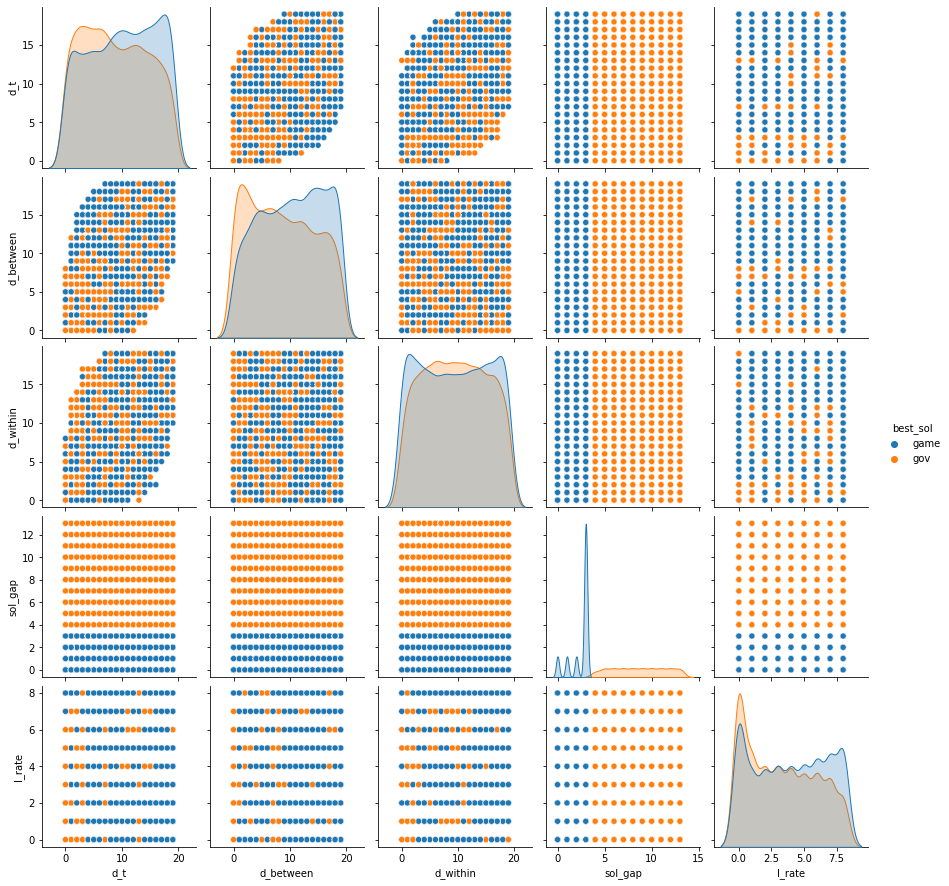

In [108]:
columns = ['d_t', 'd_between', 'd_within', 'best_sol', 'sol_gap', 'l_rate']
sns.pairplot(base_cat[columns], hue='best_sol')

In [ ]:
sns.lineplot(data=base, x="T", y="sol_gap", ci=36)#, style='nil_nil')

In [17]:
params = ['T', 'd_11', 'd_12', 'd_21', 'd_22', 'l_1', 'l_2', 'l_rate']
test = base.copy()
cat_params = []
for var in params:
    test[var + '_cat'] = pd.cut(test[var], 5)
    cat_params.append(var + '_cat')

In [20]:
test.groupby(test[cat_params].astype('str').sum(axis=1))['T'].count().max()

7

In [172]:
formula = 'y ~ ' + ' + '.join(cat_params)

mod1 = smf.glm(formula=formula, data=test, family=sm.families.Binomial()).fit()
test['pred'] = mod1.predict(test)
fpr, tpr, thresholds = metrics.roc_curve(test['y'].astype(int), test['pred'])
print('AUC: ', metrics.auc(fpr, tpr))
mod1.summary()

AUC:  0.8165527816114709


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                10979
Model:                            GLM   Df Residuals:                    10852
Model Family:                Binomial   Df Model:                          126
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5682.2
Date:                Sun, 23 Oct 2022   Deviance:                       11364.
Time:                        08:26:55   Pearson chi2:                 1.06e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.2936
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                               6.5741      0.338     19.478      0.000       5.913       7.236
T_cat[T.Interval(51.85, 101.7, closed='right')]        -2.6870      0.217    -12.366      0.000      -3.113      -2.261
T_cat[T.Interval(101.7, 151.55, closed='right')]       -3.6446      0.217    -16.810      0.000      -4.070      -3.220
T_cat[T.Interval(151.55, 201.4, closed='right')]       -4.3227      0.223    -19.412      0.000      -4.759      -3.886
T_cat[T.Interval(201.4, 251.25, closed='right')]       -4.6232      0.222    -20.866      0.000      -5.057      -4.189
T_cat[T.Interval(251.25, 301.1, closed='right')]       -4.7548      0.223    -21.308      0.000      -5.192      -4.317
T_cat[T.Interval(301.1, 350.95, closed='right')]       -4.3720      0.219    -19.963      0.000      -4.801      -3.943
T_cat[T.Interval(350.95, 400.8, closed='right')]       -4.4901      0.221    -20.319      0.000      -4.923      -4.057
T_cat[T.Interval(400.8, 450.65, closed='right')]       -4.2038      0.219    -19.229      0.000      -4.632      -3.775
T_cat[T.Interval(450.65, 500.5, closed='right')]       -4.0038      0.217    -18.447      0.000      -4.429      -3.578
T_cat[T.Interval(500.5, 550.35, closed='right')]       -3.9632      0.217    -18.249      0.000      -4.389      -3.538
T_cat[T.Interval(550.35, 600.2, closed='right')]       -3.6471      0.217    -16.808      0.000      -4.072      -3.222
T_cat[T.Interval(600.2, 650.05, closed='right')]       -3.5182      0.218    -16.173      0.000      -3.945      -3.092
T_cat[T.Interval(650.05, 699.9, closed='right')]       -3.5355      0.215    -16.439      0.000      -3.957      -3.114
T_cat[T.Interval(699.9, 749.75, closed='right')]       -3.3586      0.216    -15.532      0.000      -3.782      -2.935
T_cat[T.Interval(749.75, 799.6, closed='right')]       -3.2111      0.215    -14.942      0.000      -3.632      -2.790
T_cat[T.Interval(799.6, 849.45, closed='right')]       -3.1412      0.217    -14.484      0.000      -3.566      -2.716
T_cat[T.Interval(849.45, 899.3, closed='right')]       -2.9390      0.212    -13.841      0.000      -3.355      -2.523
T_cat[T.Interval(899.3, 949.15, closed='right')]       -2.6925      0.217    -12.384      0.000      -3.119      -2.266
T_cat[T.Interval(949.15, 999.0, closed='right')]       -2.6392      0.215    -12.303      0.000      -3.060      -2.219
d_11_cat[T.Interval(0.0125, 0.025, closed='right')]    -0.3913      0.145     -2.707      0.007      -0.675      -0.108
d_11_cat[T.Interval(0.025, 0.0375, closed='right')]    -0.4178      0.144     -2.898      0.004      -0.700      -0.135
d_11_cat[T.Interval(0.0375, 0.05, closed='right')]     -0.5857      0.149     -3.92

In [156]:
0.91*2-1

0.8200000000000001

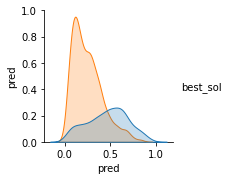

In [132]:

sns.pairplot(test[['best_sol', 'pred']], hue='best_sol')

In [10]:
hm_test = base.query('cost_sol_gov > cost_sol & msg_sol_gov == "found solution"')
hm_test.set_index(['d_11', 'd_12'], inplace=True)

In [20]:
sns.heatmap(test.query('best_sol=="game"').drop('best_sol', axis=1))

ValueError: could not convert string to float: 'd_11'

In [37]:
base.query('cost_sol > cost_sol_gov')[['d_11', 'd_12', 'd_21', 'd_22']].sum(axis=1).mean()

0.5352548689346586

In [38]:
base.query('cost_sol < cost_sol_gov')[['d_11', 'd_12', 'd_21', 'd_22']].sum(axis=1).mean()

0.4258546243229284

In [39]:
base.query('cost_sol > cost_sol_gov').eval('d_12*d_21').mean()

0.018343999469177436

In [40]:
base.query('cost_sol > cost_sol_gov')[['d_11', 'd_22', 'T']].mean()

d_11      0.140039
d_22      0.123119
T       553.483402
dtype: float64

In [41]:
base.query('cost_sol < cost_sol_gov').eval('d_12*d_21').mean()

0.004261639915904168

In [24]:
base

,T,I0,d,l,Recovered_rate,ReSusceptible_rate,time,v_sol,v_der_sol,cost_sol,msg_sol,v_sol_gov,v_der_sol_gov,cost_sol_gov,msg_sol_gov,d_11,d_12,d_21,d_22
0,914,0.037480,"[[0.8565816349272409, 0.6292831855177051], [0....","[50, 2300]",0,0,29.335019,"[[0.13220528342631357, 0.8116401933875722], [0...","[[4.804618924936221e-10, -8.510906290837283e-0...",591.848974,found solution,"[[0.062481132833233526, 0.062481132833233526],...","[[-239.78417793861823, -250.21161963344957], [...",316.343050,found solution,0.856582,0.629283,0.483606,0.908240
1,210,0.002814,"[[0.1811095865877227, 0.8615772933961338], [0....","[77, 154]",0,0,3.043460,"[[0.5083858220791662, 0.3974059127194974], [0....","[[-2.7481602327128485e-08, -1.6335377495124703...",22.342767,found solution,"[[0.372188959122877, 0.372188959122877], [0.37...","[[-5.350097044444526, -2.5515503095256253], [-...",20.813578,found solution,0.181110,0.861577,0.150991,0.959984
2,448,0.092969,"[[0.27210870926413344, 0.7953386076766586], [0...","[46, 1702]",0,0,12.776767,"[[0.2179515946389642, 0.7376240890846264], [0....","[[8.363087999896379e-12, -1.2317620257107365e-...",621.799149,found solution,"[[0.08044517647035616, 0.08044517647035616], [...","[[-148.10193159888706, -145.07554906301644], [...",450.403564,found solution,0.272109,0.795339,0.902819,0.237061
3,647,0.072381,"[[0.3221893262459786, 0.9652239563946082], [0....","[38, 798]",0,0,16.529536,"[[0.19676556812392365, 0.513278486087027], [0....","[[7.09370340246096e-11, -2.727185588469183e-09...",328.989947,found solution,"[[0.0889846695016355, 0.0889846695016355], [0....","[[-117.29241219513654, -112.9960958740204], [9...",229.319828,found solution,0.322189,0.965224,0.740347,0.458198
4,458,0.051370,"[[0.9731576326301973, 0.2951818004700274], [0....","[7, 35]",0,0,4.466413,"[[0.23738641299054425, 0.9423493485621331], [0...","[[3.0604496714659035e-10, -5.625146348720023e-...",51.060503,found solution,"[[0.22088180515676975, 0.22088180515676975], [...","[[-7.448328917304595, -18.637151466984033], [-...",39.520211,found solution,0.973158,0.295182,0.260556,0.909412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,792,0.025416,"[[0.8212704864063497, 0.2837052908809725], [0....","[20, 140]",0,0,9.007427,"[[0.18024703769729836, 0.7616229153895309], [0...","[[-4.1801584416134574e-10, -9.296900582711487e...",83.575289,found solution,"[[0.15537822189308395, 0.15537822189308395], [...","[[-24.046523310038427, -38.43112421111843], [-...",58.739820,found solution,0.821270,0.283705,0.229973,0.869230
2948,400,0.017882,"[[0.11898628366519559, 0.45504947518363503], [...","[50, 550]",0,0,2.094115,"[[0.42591439004906206, 0.8562517018068917], [0...","[[-1.509903313490213e-14, 2.042810365310288e-1...",87.958068,found solution,"[[0.22615422669284008, 0.22615422669284008], [...","[[-17.2696117909372, -15.22442606717092], [26....",64.403508,found solution,0.118986,0.455049,0.437304,0.121604
2949,903,0.075246,"[[0.3744280344312455, 0.6485019550454362], [0....","[87, 2088]",0,0,6.991305,"[[0.13164969703267537, 0.3750856223525718], [0...","[[1.4622969501942862e-10, -9.226468478118477e-...",616.322075,found solution,"[[0.06294028947463672, 0.06294028947463672], [...","[[-230.19585838102168, -233.5574628223527], [-...",473.486791,found solution,0.374428,0.648502,0.332261,0.522544
2950,657,0.090897,"[[0.49718973502944186, 0.7011242546638777], [0...","[33, 1551]",0,0,3.632560,"[[0.1684279186438112, 0.716381084588251], [0.0...","[[-2.5579538487363607e-12, 2.311484337269576e-...",622.131160,found solution,"[[0.09970753370066586, 0.09970753370066586], [...","[[-83.46315812720917, -90.22237384507537], [22...",449.958674,found solution,0.497190,0.701124,0.390621,0.036780


In [26]:
base.query('cost_sol < cost_sol_gov')[['d_11', 'd_22', 'T']].mean()

d_11      0.502530
d_22      0.172665
T       567.394737
dtype: float64

In [16]:
base.query('cost_sol < cost_sol_gov').shape

(76, 19)

In [17]:
base.query('cost_sol > cost_sol_gov').shape

(2876, 19)